<a href="https://colab.research.google.com/github/peekayitachi/Spam-Detection/blob/main/spamdetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spam Detection Program for Assignment - II

install and import important libs and load dataset

In [1]:
# Import necessary libraries

!pip install kagglehub imbalanced-learn nltk pytesseract xgboost scikit-learn ipywidgets tqdm
!sudo apt install tesseract-ocr

import kagglehub
import pandas as pd
import numpy as np
import re
import string
import nltk
import pytesseract
import cv2
import ipywidgets as widgets
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from PIL import Image
from google.colab import files
from IPython.display import display, HTML
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Download dataset from Kaggle
path = kagglehub.dataset_download("venky73/spam-mails-dataset")
file_path = f"{path}/spam_ham_dataset.csv"
df = pd.read_csv(file_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,320 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is ins

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


100%|██████████| 1.86M/1.86M [00:00<00:00, 41.2MB/s]

Extracting files...


##Pre-Processing

In [2]:
# Rename columns for consistency
df = df[['label', 'text']]
df.columns = ['label', 'message']

# Convert labels to binary (spam = 1, ham = 0)
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function for text cleaning, stopwords removal, and lemmatization
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply text preprocessing
df['message'] = df['message'].apply(preprocess_text)

# TF-IDF Vectorization (Better than simple feature extraction)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(df['message'])

# Handle Class Imbalance with SMOTE
y = df['label']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train XGBoost Model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=150)
model.fit(X_train, y_train)

# Evaluate Model Accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:21:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model Accuracy: 0.9809

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       768
           1       0.97      1.00      0.98       701

    accuracy                           0.98      1469
   macro avg       0.98      0.98      0.98      1469
weighted avg       0.98      0.98      0.98      1469



###Code for Feature extraction
The **CountVectorizer** lib is used instead of n-grams and tf-idf which was taught in class.

In [3]:
# Function to extract text from an image using Tesseract OCR
def extract_text_from_image(image_path):
    img = Image.open(image_path)  # Open image
    text = pytesseract.image_to_string(img)  # Extract text
    return text

# Function to clean OCR-extracted text
def clean_extracted_text(text):
    text = re.sub(r'\n+', ' ', text)  # Remove extra newlines
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Function to predict spam from extracted text
def predict_spam_from_text(text):
    processed_text = preprocess_text(text)
    text_tfidf = vectorizer.transform([processed_text])
    prediction = model.predict(text_tfidf)
    return "🚨 Spam 🚨" if prediction[0] == 1 else "✅ Not Spam ✅"

##Basic UI for Image upload and Spam-Detection

📸 Upload an image containing text for spam detection:


FileUpload(value={}, accept='image/*', description='Upload')

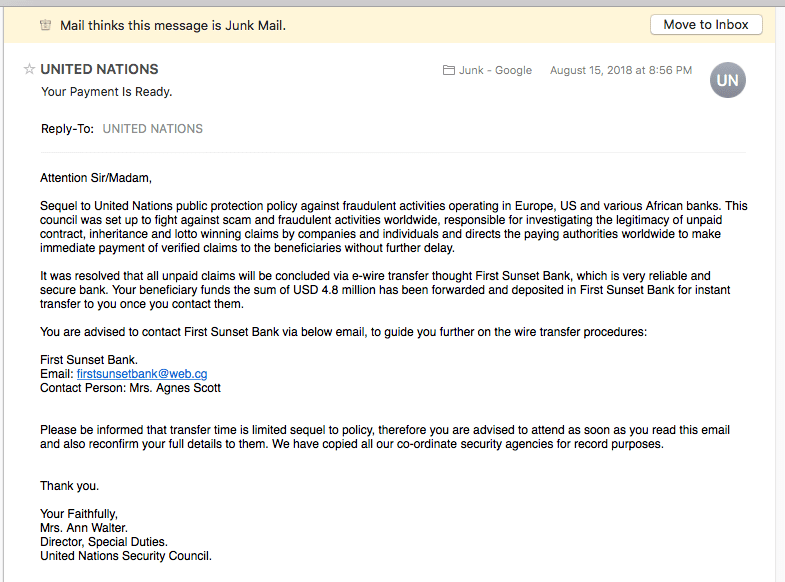

FloatProgress(value=0.0, bar_style='info', description='Processing...')

Analyzing Image: 100%|██████████| 101/101 [00:03<00:00, 32.72it/s]


In [4]:
import io
import os

def upload_image(change):
    uploaded_file = change['new']

    if uploaded_file:
        # Get the uploaded file name
        file_name = list(uploaded_file.keys())[0]

        # Save the uploaded file to disk
        file_path = f"/content/{file_name}"  # Store in Colab's working directory

        with open(file_path, "wb") as f:
            f.write(uploaded_file[file_name]["content"])

        # Display the uploaded image
        image = Image.open(file_path)
        display(image)

        # Progress bar widget
        progress = widgets.FloatProgress(min=0, max=100, description="Processing...", bar_style='info')
        display(progress)

        # Simulating progress
        for i in tqdm(range(101), desc="Analyzing Image"):
            time.sleep(0.03)
            progress.value = i

        # Extract text from image
        extracted_text = extract_text_from_image(file_path)
        extracted_text = clean_extracted_text(extracted_text)

        # Classify the extracted text
        prediction = predict_spam_from_text(extracted_text)

        # Hide the progress bar
        progress.close()

        # Display the result immediately in a dialog box
        js_code = f"""
        <script>
            var elem = document.createElement('div');
            elem.innerHTML = '<div style="position: fixed; top: 50%; left: 50%; transform: translate(-50%, -50%); padding: 20px; border-radius: 10px; background-color: #333; color: white; font-size: 20px; text-align: center; box-shadow: 0 4px 8px rgba(0,0,0,0.2);"><strong>{prediction}</strong></div>';
            document.body.appendChild(elem);
        </script>
        """
        display(HTML(js_code))

# UI Elements
upload_button = widgets.FileUpload(accept='image/*', multiple=False)

# Set action when an image is uploaded
upload_button.observe(upload_image, names='value')

# Display UI
print("📸 Upload an image containing text for spam detection:")
display(upload_button)


## Model Evaluation

###Accuracy Score

In [5]:
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Model Accuracy: 0.9809

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       768
           1       0.97      1.00      0.98       701

    accuracy                           0.98      1469
   macro avg       0.98      0.98      0.98      1469
weighted avg       0.98      0.98      0.98      1469



###Confusion Matrix

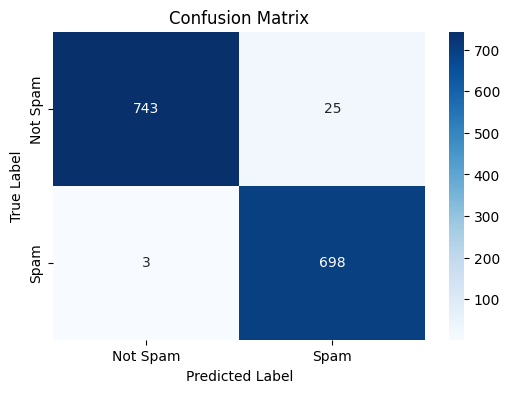

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
